The left image shows the damages and right image shows the parts, both of these can be plotted using this notebook [https://www.kaggle.com/lplenka/coco-data-visualization](https://www.kaggle.com/lplenka/coco-data-visualization)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>Source Dataset</center></h3>

**Since we will train two models, first for only damages and second for only parts, you can find annotation for both in the dataset I have published here. [Coco Car Damage Dataset](https://www.kaggle.com/lplenka/coco-car-damage-detection-dataset)**

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>Let's begin!</center></h3>

##### Since I have already shown the installation steps, here I will directly start with all installations

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>Installation</center></h3>

In [1]:
# Install Pycocotools
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# Install detectron 2
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ugq7665w
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ugq7665w
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272389 sha256=05db3731212cd700039b62b2bb4a3bd80f0fbb6f882059779e5c8c40beec0207
  Stored in directory: /tmp/pip-ephem-wheel-cache-ofjxf1qw/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
     |████████████████████████████████| 6.1 MB 28.8 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.7 MB/s  eta 0:00:01
     |████████████████████████████████| 154 kB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 8.2 MB/s  eta 0:00:01
     |████████████████████████████████| 130 kB 59.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting 

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>Import Libraries</center></h3>

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Scipy for calculating distance
from scipy.spatial import distance

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>Set constant variables</center></h3>

In [3]:
# I am visualizing some images in the 'val/' directory

dataDir='../input/coco-car-damage-detection-dataset/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "../input/coco-car-damage-detection-dataset/img"

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white; border:0' role="tab" aria-controls="home"><center style='padding-top: 15px'> Initialize the COCO API</center></h3>

In [4]:
# initialize coco api for instance annotations
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px' > Import Libraries required for training</center></h3>

In [5]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.0 True


In [6]:
assert torch.__version__.startswith("1.7")

In [7]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [8]:
# To find out inconsistent CUDA versions, if there is no "failed" word in this output then things are fine.
!python -m detectron2.utils.collect_env

----------------------  ------------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) [GCC 9.3.0]
numpy                   1.19.5
detectron2              0.5 @/opt/conda/lib/python3.7/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.2
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.0 @/opt/conda/lib/python3.7/site-packages/torch
PyTorch debug build     True
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
CUDA_HOME               /usr/local/cuda
Pillow                  7.2.0
torchvision             0.8.1 @/opt/conda/lib/python3.7/site-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5
fvcore                  0.1.5.post20221221
iopath                  0.1.8
cv2                     4.5.1
----

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>  Register Car Damage Dataset </center></h3>

#### Register Train Dataset, so that we can use its Metadata

In [9]:

dataset_dir = "../input/coco-car-damage-detection-dataset"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_mul_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white; ' role="tab" aria-controls="home"><center style='padding-top: 15px'> Load trained model </center></h2>

#### I will load two pretained models:

* Damage Segmentation model weights -  This can be easily created using this notebook [
Detectron2 Car Damage Detection](https://www.kaggle.com/lplenka/detectron2-car-damage-detection). The model is stored in default output directory.

* Parts Segmentation Model weights - This can be also created just changing the dataset from damage annotions to parts annotation in [cell 22](https://www.kaggle.com/lplenka/detectron2-car-damage-detection?scriptVersionId=52171508&cellId=37)



<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white; ' role="tab" aria-controls="home"><center style='padding-top: 15px'> Damage Detection Model </center></h2>

In [11]:
#get configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 2 # only has one class (damage) + 1
cfg.MODEL.WEIGHTS = os.path.join("../input/coco-damage-detection-trained-models/damage_segmentation_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg['MODEL']['DEVICE']='cuda'#or cpu
damage_predictor = DefaultPredictor(cfg)


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white; ' role="tab" aria-controls="home"><center style='padding-top: 15px'> Parts Segmentation Model </center></h2>

In [12]:
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 6  # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 6 # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.WEIGHTS = os.path.join("../input/coco-damage-detection-trained-models/part_segmentation_model.pth")
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg_mul['MODEL']['DEVICE']='cuda' #or cpu
part_predictor = DefaultPredictor(cfg_mul)

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Model Inference </center></h2>

In [13]:
def detect_damage_part(damage_dict, parts_dict):
  """
  Returns the most plausible damaged part for the list of damages by checking the distance 
  between centers centers of damage_polygons and parts_polygons

  Parameters
  -------------
   damage_dict: dict
                Dictionary that maps damages to damage polygon centers.
   parts_dict: dict
                Dictionary that maps part labels to parts polygon centers.
  Return
  ----------
  part_name: str
            The most plausible damaged part name.
  """
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    for y in parts_dict.keys():
        for x in damage_dict.keys():
          dis = distance.euclidean(damage_dict[x], parts_dict[y])
          if dis < max_distance_dict[x]:
            part_name[x] = y.rsplit('_',1)[0]

    return list(set(part_name.values()))
  except Exception as e:
    print(e)

In [14]:

damage_class_map= {0:'damage'}
parts_class_map={0:'headlamp',1:'rear_bumper', 2:'door', 3:'hood', 4: 'front_bumper'}

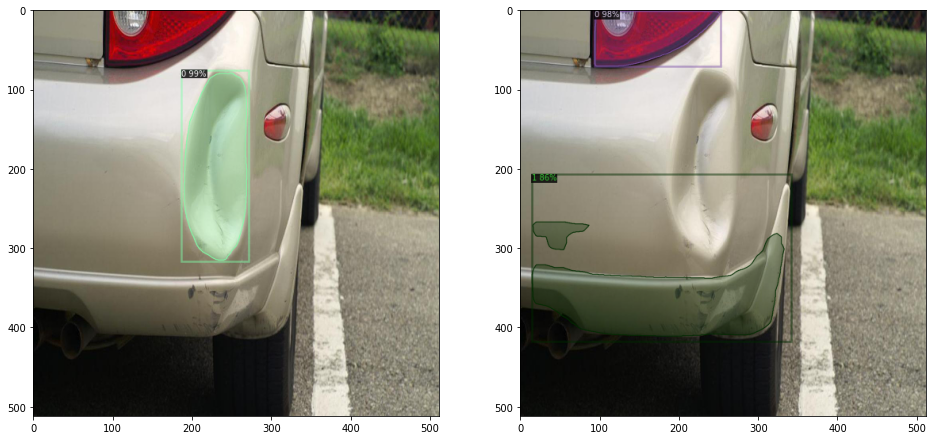

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("../input/coco-car-damage-detection-dataset/val/1.jpg")

#damage inference
damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

#part inference
parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

#plot
ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Create damage polygons </center></h2>

For now allowing multiple polygons of same class label

In [26]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Create parts polygons </center></h2>

For now allowing multiple polygons of same class label

In [27]:

parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()



#Remove centers which lie in beyond 800 units
parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Damaged Parts </center></h2>

In [28]:
print("Damaged Parts: ",detect_damage_part(damage_dict,parts_dict))

Damaged Parts:  ['rear_bumper']
